In [ ]:
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121
!pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'
!pip install cython pyyaml==5.1

In [ ]:
!pip install 'git+https://github.com/facebookresearch/detectron2.git'

In [ ]:
!pip install clearml

In [1]:
%env CLEARML_WEB_HOST=https://app.clear.ml/
%env CLEARML_API_HOST=https://api.clear.ml
%env CLEARML_FILES_HOST=https://files.clear.ml
%env CLEARML_API_ACCESS_KEY=74E1MQT3ZZD05XEGU9KGLQCZWEH1I0
%env CLEARML_API_SECRET_KEY=BqXaAM3UWu2XHbEznD2adyrzQlMy1q5vsWgiM4JHVu0e03YUbuFhVoJd7RbbILZATRE

env: CLEARML_WEB_HOST=https://app.clear.ml/
env: CLEARML_API_HOST=https://api.clear.ml
env: CLEARML_FILES_HOST=https://files.clear.ml
env: CLEARML_API_ACCESS_KEY=74E1MQT3ZZD05XEGU9KGLQCZWEH1I0
env: CLEARML_API_SECRET_KEY=BqXaAM3UWu2XHbEznD2adyrzQlMy1q5vsWgiM4JHVu0e03YUbuFhVoJd7RbbILZATRE


In [2]:
!clearml-init

from clearml import Task

task = Task.init(project_name="DeepFashion", task_name="DeepFashion_mask_rcnn_R_50_FPN_3x_171124")

ClearML SDK setup process

Please create new clearml credentials through the settings page in your `clearml-server` web app (e.g. http://localhost:8080//settings/workspace-configuration) 
Or create a free account at https://app.clear.ml/settings/workspace-configuration

In settings page, press "Create new credentials", then press "Copy to clipboard".

Paste copied configuration here:
^C
Traceback (most recent call last):
  File "/opt/conda/bin/clearml-init", line 8, in <module>
    sys.exit(main())
  File "/opt/conda/lib/python3.10/site-packages/clearml/cli/config/__main__.py", line 82, in main
    api_input = input()
KeyboardInterrupt
ClearML Task: overwriting (reusing) task id=370b3d54931849ecbd816901e57b38a9
2024-11-17 14:29:38,057 - clearml.Repository Detection - WARNING - Jupyter Notebook auto-logging failed, could not access: /kaggle/working/__notebook_source__.ipynb
2024-11-17 14:29:38,073 - clearml.Task - INFO - Storing jupyter notebook directly as code
ClearML results page: ht

/opt/conda/lib/python3.10/site-packages/clearml/utilities/process/mp.py:629: RuntimeWarning:

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.



ClearML Monitor: Could not detect iteration reporting, falling back to iterations as seconds-from-start


In [3]:
import torch
import detectron2
from detectron2.utils.logger import setup_logger
import os

setup_logger()

from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog

In [4]:
from detectron2.data.datasets import register_coco_instances
register_coco_instances("deepfashion_train", {}, "/kaggle/input/df2-train-img/ann_train.json", "/kaggle/input/df2-train-img/train_image/image")
register_coco_instances("deepfashion_val", {}, "/kaggle/input/df2-img-val/ann_val.json", "/kaggle/input/df2-img-val/image/image")

In [5]:
cfg = get_cfg()

cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
cfg.DATASETS.TRAIN = ("deepfashion_train",)
cfg.DATASETS.TEST = ()

cfg.SOLVER.BASE_LR = 0.002
cfg.SOLVER.MAX_ITER = 5000
cfg.SOLVER.WARMUP_ITERS = int(0.1 * cfg.SOLVER.MAX_ITER)  # 10% of training as warm-up
# cfg.SOLVER.STEPS = (2000, 5000)
cfg.SOLVER.GAMMA = 0.1      # Less aggressive decay

cfg.SOLVER.IMS_PER_BATCH = 8
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 256  # Improves sampling quality
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 13 

cfg.SOLVER.WEIGHT_DECAY = 0.0001

cfg.SOLVER.CHECKPOINT_PERIOD = 1000  # Save model every 1000 iterations

cfg.TEST.EVAL_PERIOD = 1000
cfg.OUTPUT_DIR = "/kaggle/working"
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)

In [6]:
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)

[11/17 14:30:05 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

In [7]:
trainer.train()

[11/17 14:33:35 d2.engine.train_loop]: Starting training from iteration 0


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning:

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.

/opt/conda/lib/python3.10/site-packages/torch/functional.py:513: UserWarning:

torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /usr/local/src/pytorch/aten/src/ATen/native/TensorShape.cpp:3609.)



[11/17 14:34:00 d2.utils.events]:  eta: 1:36:12  iter: 19  total_loss: 3.672  loss_cls: 2.663  loss_box_reg: 0.2878  loss_mask: 0.6927  loss_rpn_cls: 0.01551  loss_rpn_loc: 0.01557    time: 1.1354  last_time: 1.1944  data_time: 0.0981  last_data_time: 0.0756   lr: 7.7924e-05  max_mem: 9360M
[11/17 14:34:23 d2.utils.events]:  eta: 1:35:49  iter: 39  total_loss: 1.954  loss_cls: 0.7951  loss_box_reg: 0.3191  loss_mask: 0.6853  loss_rpn_cls: 0.01801  loss_rpn_loc: 0.01932    time: 1.1437  last_time: 1.2195  data_time: 0.0563  last_data_time: 0.0615   lr: 0.00015784  max_mem: 9361M
[11/17 14:34:46 d2.utils.events]:  eta: 1:35:18  iter: 59  total_loss: 1.45  loss_cls: 0.4232  loss_box_reg: 0.3361  loss_mask: 0.6729  loss_rpn_cls: 0.01382  loss_rpn_loc: 0.01525    time: 1.1495  last_time: 1.2681  data_time: 0.0603  last_data_time: 0.0705   lr: 0.00023776  max_mem: 9361M
[11/17 14:35:09 d2.utils.events]:  eta: 1:34:37  iter: 79  total_loss: 1.453  loss_cls: 0.4026  loss_box_reg: 0.3669  loss_

In [9]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader

cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.55
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.DATASETS.TEST = ("deepfashion_val",)

evaluator = COCOEvaluator("deepfashion_val", cfg, False, output_dir=cfg.OUTPUT_DIR)
val_loader = build_detection_test_loader(cfg, "deepfashion_val")

WARNING [11/17 16:14:50 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
[11/17 16:15:26 d2.data.datasets.coco]: Loading /kaggle/input/df2-img-val/ann_val.json takes 16.15 seconds.
[11/17 16:15:27 d2.data.datasets.coco]: Loaded 32153 images in COCO format from /kaggle/input/df2-img-val/ann_val.json
[11/17 16:15:39 d2.data.build]: Distribution of instances among all 13 categories:
|   category    | #instances   |   category    | #instances   |   category    | #instances   |
|:-------------:|:-------------|:-------------:|:-------------|:-------------:|:-------------|
| short sleev.. | 12556        | long sleeve.. | 5966         | short sleev.. | 142          |
| long sleeve.. | 2011         |     vest      | 2113         |     sling     | 322          |
|    shorts     | 4167         |   trousers    | 9586         |     skirt     | 6522         |
| short sleev.. | 3127         | long sleeve.

In [10]:
metrics = inference_on_dataset(trainer.model, val_loader, evaluator)
print("Validation Metrics:", metrics)

[11/17 16:15:54 d2.evaluation.evaluator]: Start inference on 32153 batches


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning:

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.



[11/17 16:15:56 d2.evaluation.evaluator]: Inference done 11/32153. Dataloading: 0.0022 s/iter. Inference: 0.0821 s/iter. Eval: 0.0130 s/iter. Total: 0.0974 s/iter. ETA=0:52:09
[11/17 16:16:01 d2.evaluation.evaluator]: Inference done 76/32153. Dataloading: 0.0018 s/iter. Inference: 0.0688 s/iter. Eval: 0.0079 s/iter. Total: 0.0787 s/iter. ETA=0:42:04
[11/17 16:16:06 d2.evaluation.evaluator]: Inference done 144/32153. Dataloading: 0.0018 s/iter. Inference: 0.0675 s/iter. Eval: 0.0069 s/iter. Total: 0.0764 s/iter. ETA=0:40:44
[11/17 16:16:11 d2.evaluation.evaluator]: Inference done 212/32153. Dataloading: 0.0018 s/iter. Inference: 0.0670 s/iter. Eval: 0.0066 s/iter. Total: 0.0755 s/iter. ETA=0:40:10
[11/17 16:16:16 d2.evaluation.evaluator]: Inference done 279/32153. Dataloading: 0.0019 s/iter. Inference: 0.0669 s/iter. Eval: 0.0064 s/iter. Total: 0.0753 s/iter. ETA=0:40:01
[11/17 16:16:21 d2.evaluation.evaluator]: Inference done 350/32153. Dataloading: 0.0019 s/iter. Inference: 0.0664 s/i

/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning:

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.



[11/17 16:56:36 d2.evaluation.evaluator]: Total inference time: 0:40:39.948426 (0.075897 s / iter per device, on 1 devices)
[11/17 16:56:36 d2.evaluation.evaluator]: Total inference pure compute time: 0:35:07 (0.065546 s / iter per device, on 1 devices)
2024-11-17 16:56:42,793 - clearml.frameworks - INFO - Found existing registered model id=173acd991d2340d0be80f350d4bca638 [/kaggle/working/instances_predictions.pth] reusing it.
[11/17 16:56:46 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[11/17 16:56:47 d2.evaluation.coco_evaluation]: Saving results to /kaggle/working/coco_instances_results.json
[11/17 16:56:51 d2.evaluation.coco_evaluation]: Evaluating predictions with unofficial COCO API...
Loading and preparing results...
DONE (t=0.51s)
creating index...
index created!
[11/17 16:56:51 d2.evaluation.fast_eval_api]: Evaluate annotation type *bbox*
[11/17 16:57:13 d2.evaluation.fast_eval_api]: COCOeval_opt.evaluate() finished in 21.52 seconds.
[11/17 16:57:13 d

In [11]:
cfg.DATASETS.TEST = ("deepfashion_val", )
predictor = DefaultPredictor(cfg)

[11/17 17:08:17 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from /kaggle/working/model_final.pth ...


/opt/conda/lib/python3.10/site-packages/clearml/binding/frameworks/pytorch_bind.py:277: FutureWarning:

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.



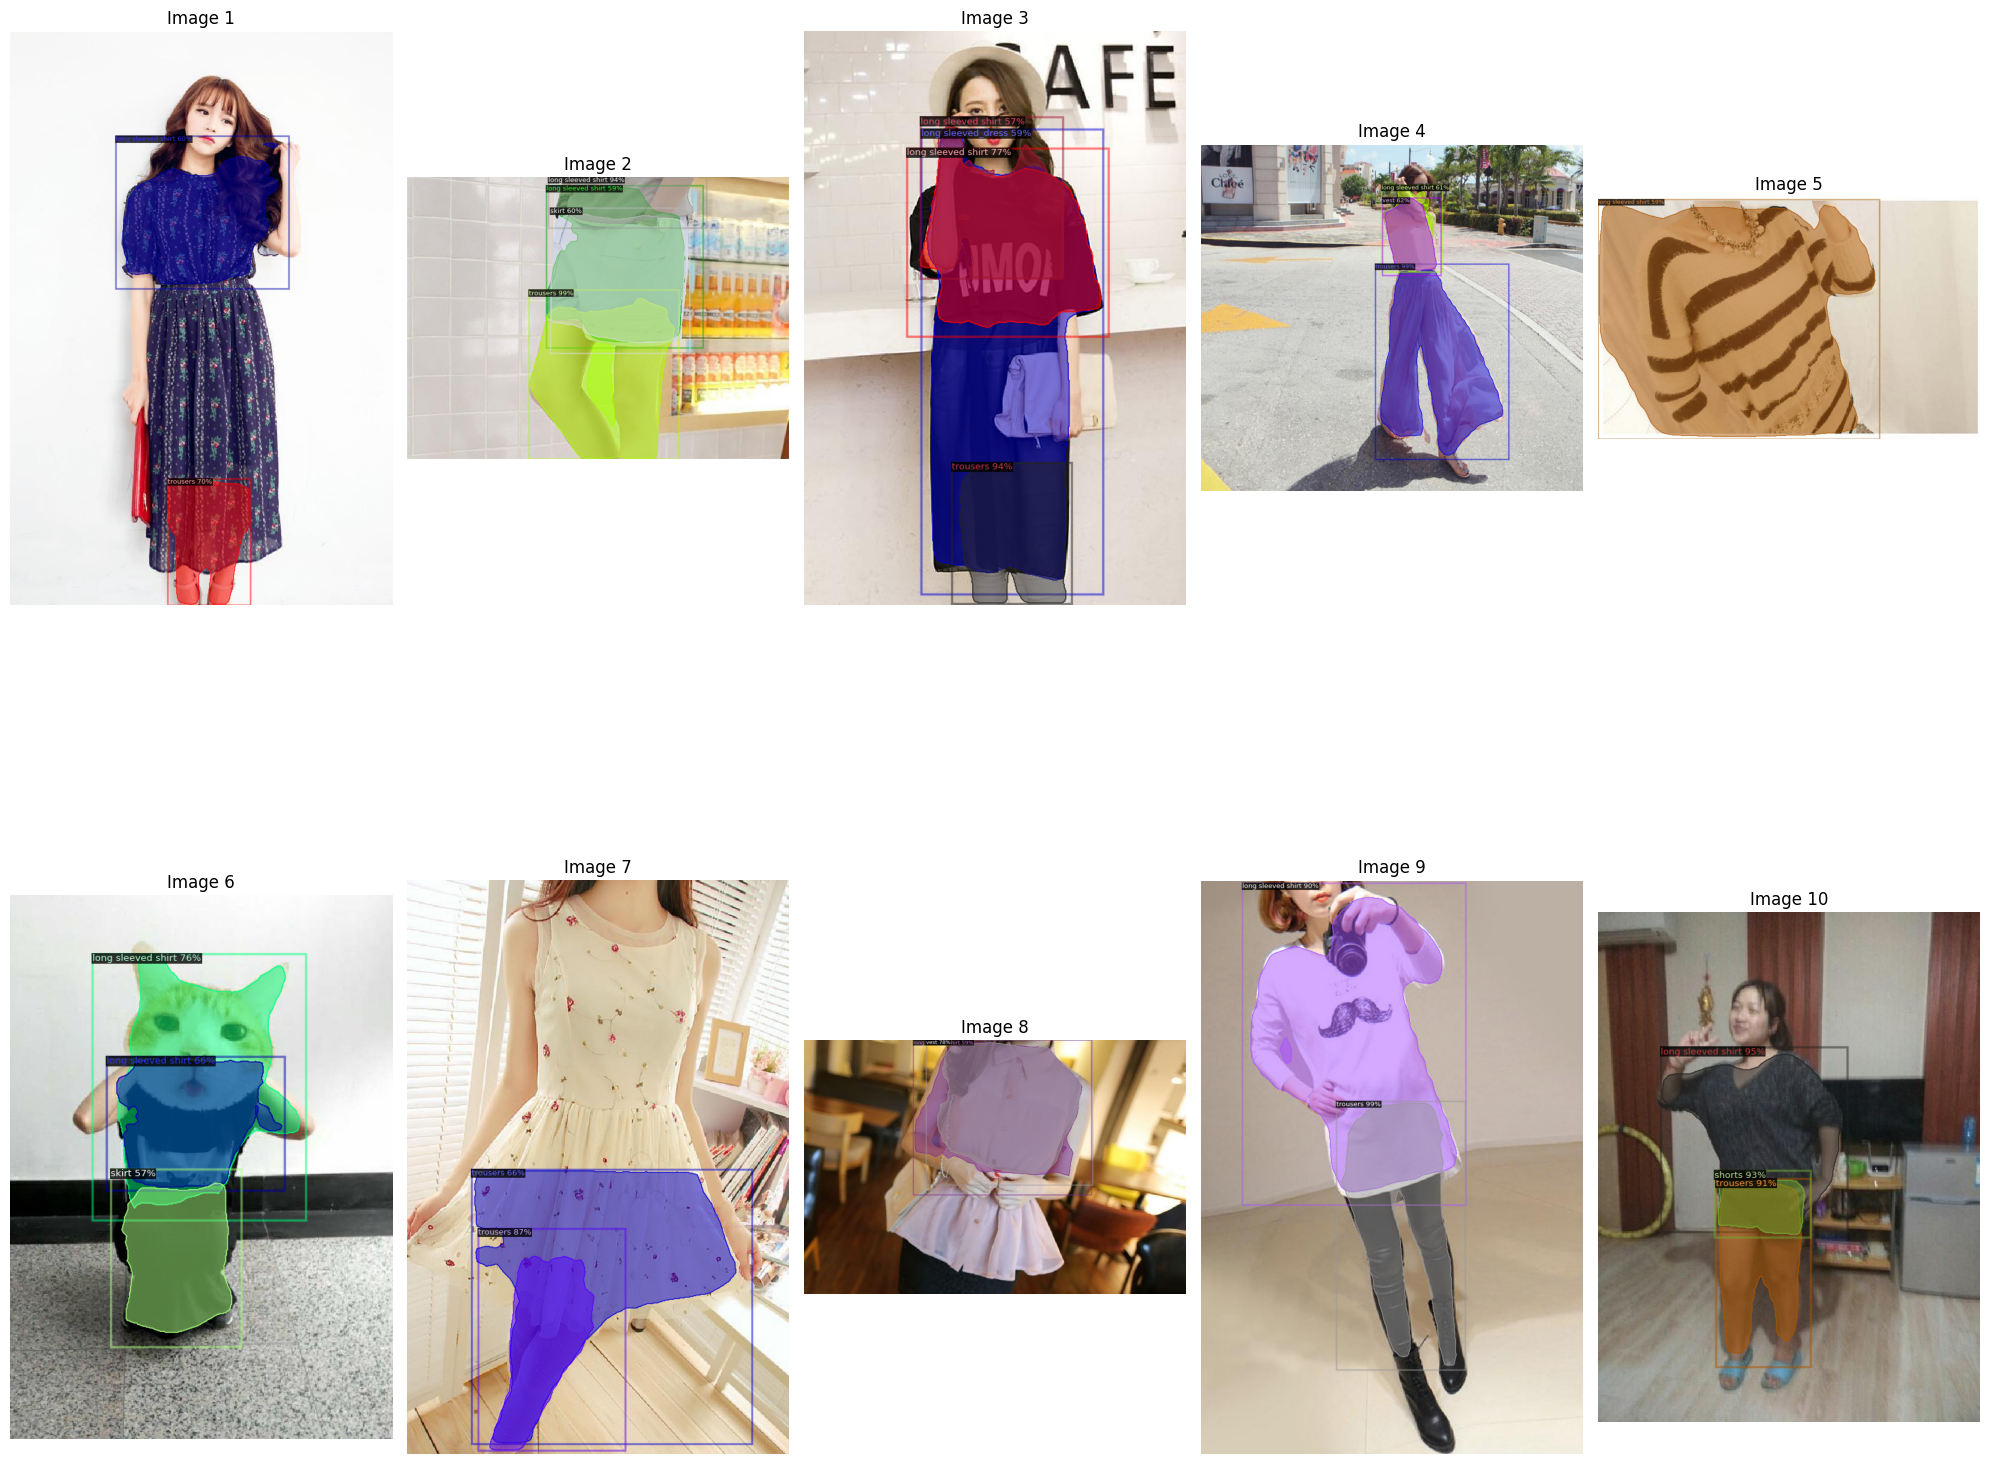

In [13]:
import os
import random
import cv2
import matplotlib.pyplot as plt
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog

image_dir = "/kaggle/input/df2-img-val/image/image"

image_files = [os.path.join(image_dir, f) for f in os.listdir(image_dir) if f.endswith(".jpg")]

plt.figure(figsize=(20, 20))
for i in range(10):
    # Select a random image
    img_path = random.choice(image_files)
    
    im = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
    
    outputs = predictor(im)
    
    v = Visualizer(im, MetadataCatalog.get(cfg.DATASETS.TEST[0]), scale=1.2)
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    
    plt.subplot(2, 5, i + 1) 
    plt.imshow(v.get_image())
    plt.axis("off")
    plt.title(f"Image {i + 1}")

plt.tight_layout()
plt.show()


In [14]:
from IPython.display import FileLink

FileLink("model_final.pth")

/kaggle/working/model_final.pth